In [1]:
import torch
import numpy as np
from torchvision import datasets, transforms
from pathlib import Path
import spyrit.misc.walsh_hadamard as wh

from spyrit.misc.statistics import stat_walsh_stl10
from spyrit.misc.statistics import *
from spyrit.misc.disp import *

In [2]:
img_size = 64 # image size
M = 1024    # number of measurements
N0 = 10     # Image intensity (in photons)
bs = 10 # Batch size

#- Model and data paths
data_root = Path('../../data/')
stats_root = Path('../../data/stats_walsh')

In [3]:
#%% A batch of STL-10 test images
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(7)

transform = transforms.Compose(
    [transforms.functional.to_grayscale,
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

testset = \
    torchvision.datasets.STL10(root=data_root, split='test',download=False, transform=transform)
testloader =  torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)

In [4]:
inputs, _ = next(iter(testloader))
b,c,h,w = inputs.shape

In [5]:
# stat_walsh_stl10()
Cov = np.load(stats_root / Path("Cov_{}x{}.npy".format(img_size, img_size)))
Mean = np.load(stats_root / Path("Average_{}x{}.npy".format(img_size, img_size)))
H =  wh.walsh2_matrix(img_size)
# H =  wh.walsh2_matrix(img_size)/img_size
# Cov /= img_size*img_size # THIS NEEDS TO BE NORMALIAZED FOR CONSISTENCY!


Ord = Cov2Var(Cov)
Perm = Permutation_Matrix(Ord)
Pmat = np.dot(Perm,H);
Pmat = Pmat[:M,:];


In [6]:
x = inputs.view(b*c,w*h)

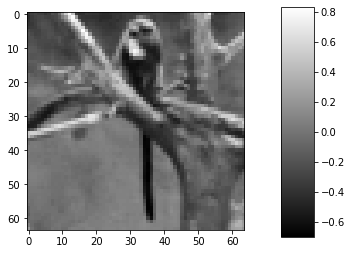

In [7]:
img = x[1,:]
img = img.numpy();
imagesc(np.reshape(img,(h,w)))

In [8]:
from spyrit.restructured.Updated_Had_Dcan import * 

In [9]:
FO = Forward_operator(Pmat)
FO_split = Split_Forward_operator(Pmat)

# Acquisition
## Instancier

In [10]:
A = Acquisition(FO);

## Test methode forward

In [11]:
y = 2*A(x)-FO.Forward_op(torch.ones_like(x))

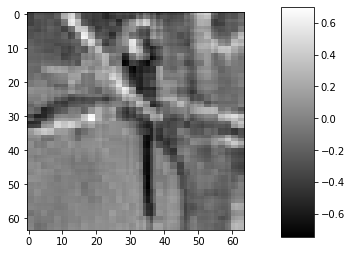

In [12]:
x_est = FO.adjoint(y)
img = 1/(w*h)*x_est[1,:]
img = img.numpy();
imagesc(np.reshape(img,(h,w)))

# Bruit_Poisson_approx_Gauss 
## Instancier

In [13]:
A_b = Bruit_Poisson_approx_Gauss(N0, FO_split)

## Test methode forward

In [14]:
m = A_b(x)

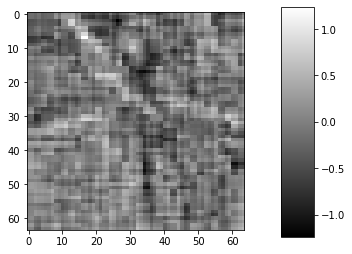

In [15]:
even_index = range(0,2*M,2);
odd_index = range(1,2*M,2);
mplus = m[:, even_index];
mminus = m[:, odd_index];
y = 2*(mplus-mminus)/N0 - FO_split.Forward_op(torch.ones_like(x))

x_est = FO.adjoint(y)
img = 1/(w*h)*x_est[1,:]
img = img.numpy();
imagesc(np.reshape(img,(h,w)))

Montrer images avec plusieurs N0

# Bruit_Poisson_Pytorch 
## Instancier

In [16]:
A_b = Bruit_Poisson_Pytorch(N0, FO_split)

## Test methode forward

In [17]:
m = A_b(x)

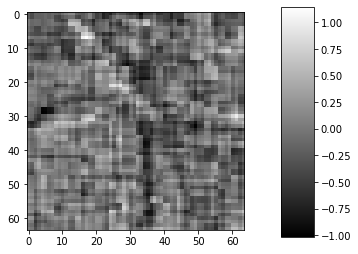

In [18]:
even_index = range(0,2*M,2);
odd_index = range(1,2*M,2);
mplus = m[:, even_index];
mminus = m[:, odd_index];
y = 2*(mplus-mminus)/N0 - FO(torch.ones_like(x))

x_est = FO.adjoint(y)
img = 1/(w*h)*x_est[1,:]
img = img.numpy();
imagesc(np.reshape(img,(h,w)))

TO DO :
* Test that the Gaussian approx is the same as the pytorch one
* Check which one is faster
* Implement Gaussian additive noise
* Implement Mixed Poisson-Gaussian Noise
* Check Mean and Var of noisy measurements (is it equal to $N0*A(x)$
    

http://wiki.stat.ucla.edu/socr/index.php/AP_Statistics_Curriculum_2007_Limits_Norm2Poisson